In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define Parameters

In [2]:
# Define system matrices
tau = 0.1
A = np.array([[1, tau, 0, 0], 
              [0, 1, 0, 0],
              [0, 0, 1, tau],
              [0, 0, 0, 1]])  
B = np.array([[0.5 * tau ** 2, 0],
              [tau, 0],
              [0, 0.5 * tau ** 2],
              [0, tau]])  


In [3]:
# Define operational domain
x_limits = [0, 5]
y_limits = [0, 5]
vel_limits = [-1, 1]

# Define unsafe regions (obstacles)
unsafe_regions = [
    [[1, -1, 1, -1], [2, 1, 2, 1]],
    [[1, -1, 3, -1], [2, 1, 5, 1]],
    [[3, -1, 1, -1], [4, 1, 2, 1]],
    [[3, -1, 2.5, -1], [4, 1, 3.5, 1]]
]

# Define target set
target_set = [[4, -0.1, 4, -0.1], [5, 0.1, 5, 0.1]]

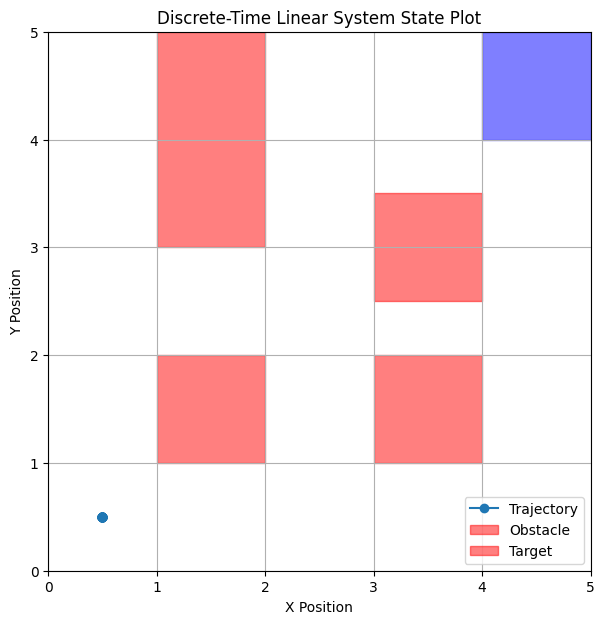

In [4]:
# Parameters
tend = 50

# Initialization
x_init = np.array([0.5, 0, 0.5, 0])  # Initial position and velocity
u_init = np.array([0, 0])
trajectory = [x_init]
input = [u_init]

for k in range(tend):
    x_next = A @ trajectory[-1] + B @ input[-1] 
    trajectory.append(x_next)

trajectory = np.array(trajectory)

# Plot trajectory of x over time
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Discrete-Time Linear System State Plot")

ax.plot(trajectory[:, 0], trajectory[:, 2], marker="o", linestyle="-", label="Trajectory")

# Plot obstacles and target set
for region in unsafe_regions:
    bottom_left = [region[0][0], region[0][2]]
    width = region[1][0] - region[0][0]
    height = region[1][2] - region[0][2]
    ax.add_patch(plt.Rectangle(bottom_left, width, height, color='red', alpha=0.5, label="Obstacle"))

bottom_left = [target_set[0][0], target_set[0][2]]
width = target_set[1][0] - target_set[0][0]
height = target_set[1][2] - target_set[0][2]
ax.add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5, label="Target"))

ax.legend(["Trajectory","Obstacle","Target"])
plt.grid(True)
plt.show()

## Helper Functions

In [5]:
def is_out_of_bounds(state):
    """Check if the state is out of the allowed operational domain."""
    x, vx, y, vy = state
    if not (x_limits[0] <= x <= x_limits[1]):
        return True
    if not (y_limits[0] <= y <= y_limits[1]):
        return True
    if not (vel_limits[0] <= vx <= vel_limits[1]):
        return True
    if not (vel_limits[0] <= vy <= vel_limits[1]):
        return True
    return False

def is_inside_obstacle(state):
    """Check if the state is inside any of the obstacles."""
    x, _, y, _ = state  # We only care about position
    for lower, upper in unsafe_regions:
        if lower[0] <= x <= upper[0] and lower[2] <= y <= upper[2]:
            return True  # Inside an obstacle
    return False

def is_illegal_state(state):
    """Determine if the state is illegal (out of bounds or inside an obstacle)."""
    return is_out_of_bounds(state) or is_inside_obstacle(state)

def distance_to_target(state):
    """Compute the Euclidean distance from the state to the center of the target set."""
    position = np.array([state[0], state[2]])  # Extract x and y positions
    target_position = np.array([4.5, 4.5])
    return np.linalg.norm(position - target_position)

# Example test cases
test_states = [
    np.array([0.5, 0.5, 0.5, 0.5]),  # Valid
    np.array([5.1, 0, 4, 0]),  # Out of bounds (x)
    np.array([1.5, 0, 1.5, 0]),  # Inside an obstacle
    np.array([4.5, 0, 4.5, 0]),  # Target set center
]

# Run tests
for i, state in enumerate(test_states):
    print(f"State {i+1}: {state}")
    print(f"  - Out of bounds: {is_out_of_bounds(state)}")
    print(f"  - Inside obstacle: {is_inside_obstacle(state)}")
    print(f"  - Illegal state: {is_illegal_state(state)}")
    print(f"  - Distance to target: {distance_to_target(state):.2f}")
    print()


# functions to compare two x_k+1 see which is closer to the target zone

State 1: [0.5 0.5 0.5 0.5]
  - Out of bounds: False
  - Inside obstacle: False
  - Illegal state: False
  - Distance to target: 5.66

State 2: [5.1 0.  4.  0. ]
  - Out of bounds: True
  - Inside obstacle: False
  - Illegal state: True
  - Distance to target: 0.78

State 3: [1.5 0.  1.5 0. ]
  - Out of bounds: False
  - Inside obstacle: True
  - Illegal state: True
  - Distance to target: 4.24

State 4: [4.5 0.  4.5 0. ]
  - Out of bounds: False
  - Inside obstacle: False
  - Illegal state: False
  - Distance to target: 0.00



## Method 1. Mixed Integer Linear Programming

Start with Problem Formation:

Define $N$ as the horizontal variable (time to reach the terminal set), which we will optimize, $\gamma$ as our choice of weight which we may use to balance our cost of control and terminal time.
$$\begin{equation} min N + \gamma\sum^n_{k=0}||u_k|| \end{equation}$$
$s.t.$
$$\begin{equation}\tag{IC}  x_0 = x_{init} \end{equation}$$
$$\begin{equation}\tag{DE}  x_{k+1} = Ax_k+Bu_k\end{equation}$$
$$\begin{equation}\tag{BC1}  x_{k+1} \in \mathcal{X} \end{equation}$$
$$\begin{equation}\tag{BC2}  u_k \in \mathcal{U} \end{equation}$$
$$\begin{equation}\tag{Obstacle Condition}  x_{k+1} \notin \mathcal{X}_U^j, 1 \leq j \leq N_o \end{equation}$$
$$\begin{equation}\tag{Target Condition}  x_{k+1} \in \mathcal{X}_T \end{equation}$$

Where
$$0\leq k \leq N $$
$$ A = 
\begin{bmatrix} 
1 & \tau & 0 & 0\\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \tau \\
0 & 0 & 0 & 1
\end{bmatrix},
B = 
\begin{bmatrix} 
0.5\tau^2 & 0\\
\tau & 0 \\
0 & 0.5\tau^2 \\
0 & \tau
\end{bmatrix}
$$

One way of formulating the inequalities so it becomes a MPC-MILP (Model Predictive Control Mixed Integer Linear Programming) and can be solved using the algorithms presented in Schouwenaars et al (2001), is to use binary variables.

Consider the obstacles set as the intersection of 4 half planes:
$$\mathcal{X}^j_U = \{p_jCx \leq q_j\}$$
where $p_j$ denotes the constant matrix in the left hand side of the half-plane inequalities defining obstacle $\mathcal{X}^j_U$, and $q_j$ denotes the right hand side of the half plane inequalities, $C$ denotes the matrix that extracts position information from the state vector $x$.

E.g. $\mathcal{X}^1_U$, defined by the lower left extreme [1, 1] and upper right extreme [2, 2] can be represented as:
$$
\mathcal{X}^1_U = \{p_1Cx \leq q_1 \}
$$
where
$$ C= 
\begin{bmatrix} 
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 \\
\end{bmatrix}
$$
$$
p_1 = 
\begin{bmatrix} 
-1 & 0\\
1 & 0 \\
0 & -1 \\
0 & 1
\end{bmatrix}
$$
$$
q_1 = 
\begin{bmatrix} 
-1\\
2 \\
-1 \\
2
\end{bmatrix}
$$

To ensure the inequality above would never hold for any $x_k$, we use big-M (a large number $M$ as a penalty for entering the obstacle) and binary variables $b_j^{obs} = \{1, 0\}$ for each obstacles. 1 if $x_k$ is outside obstacle j, and 0 if $x_k$ is inside. We also introduced $b_i^{hor}$ to keep track of obstacles we have passed horizontally (=1 if passed the obstacle, =0 if not yet pass) and a small buffer $\epsilon > 0$ to ensure $x_k$ does not graze the obstacle:
$$p_j^{obs}Cx \leq q_j^{obs} + M(1 - b_j^{obs}) - \epsilon + M\sum^{k-1}_{i=0} b^{hor}_i$$

In [6]:
# first import the Model class from docplex.mp
from docplex.mp.model import Model

In [ ]:
# create one model instance, with a name
milp_model = Model(name='Reach Avoid')

In [7]:
N = 30  # Time horizon
M = 1000  # Big-M constant
epsilon = 0.1

In [ ]:
# Decision variables
N = milp_model.integer_var(name=f"{N} steps")
x = {(k, i): milp_model.continuous_var(name=f"x_{k}_{i}") for k in range(N+1) for i in range(4)}
u = {(k, i): milp_model.continuous_var(name=f"u_{k}_{i}") for k in range(N) for i in range(2)}
z = {(k, j): milp_model.binary_var(name=f"z_{k}_{j}") for k in range(N) for j in range(len(unsafe_regions))}

# Initial state
x_init = np.array([0.5, 0.5, 0.5, 0.5])
for i in range(4):
    model.add_constraint(x[0, i] == x_init[i])

# Dynamics constraints
for k in range(N):
    for i in range(4):
        model.add_constraint(
            x[k + 1, i] == sum(A[i, j] * x[k, j] for j in range(4)) + sum(B[i, j] * u[k, j] for j in range(2))
        )

# Control constraints
for k in range(N):
    for i in range(2):
        model.add_constraint(u[k, i] >= -1)
        model.add_constraint(u[k, i] <= 1)

# Obstacle avoidance constraints
for k in range(N):
    for j, region in enumerate(unsafe_regions):
        lower, upper = region
        model.add_constraint(x[k, 0] <= lower[0] - epsilon + M * (1 - z[k, j]))
        model.add_constraint(x[k, 0] >= upper[0] + epsilon - M * z[k, j])
        model.add_constraint(x[k, 2] <= lower[2] - epsilon + M * (1 - z[k, j]))
        model.add_constraint(x[k, 2] >= upper[2] + epsilon - M * z[k, j])
    model.add_constraint(sum(z[k, j] for j in range(len(unsafe_regions))) >= 1)

# Target constraint
model.add_constraint(x[N, 0] >= target_set[0][0])
model.add_constraint(x[N, 0] <= target_set[1][0])
model.add_constraint(x[N, 2] >= target_set[0][2])
model.add_constraint(x[N, 2] <= target_set[1][2])

# Objective: Minimize control effort
model.minimize(model.sum(model.abs(u[k, i]) for k in range(N) for i in range(2)))

# Solve model
solution = model.solve()

# Check solution
if solution:
    print("Solution found:")
    trajectory = np.array([[solution.get_value(x[k, i]) for i in range(4)] for k in range(N+1)])
    print(trajectory)
else:
    print("No feasible solution found.")

No feasible solution found.


In [47]:
model.print_information()

Model: Reach Avoid
 - number of variables: 804
   - binary=200, integer=0, continuous=604
 - number of constraints: 1458
   - linear=1458
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [ ]:


# Define the number of time steps
N = 50  # Planning horizon

# Define decision variables
x = cp.Variable((4, N+1))  # State variables (position and velocity)
u = cp.Variable((2, N))    # Control inputs

# Binary variables for obstacle avoidance
z = cp.Variable((4, N), boolean=True)  # One for each obstacle

# Define the initial state
x0 = np.array([0.5, 0.5, 0.5, 0.5])  # Start position and velocity
target_center = np.array([4.5, 0, 4.5, 0])  # Center of the target set

# Define constraints
constraints = []

# 1. System dynamics constraints
for k in range(N):
    constraints.append(x[:, k+1] == A @ x[:, k] + B @ u[:, k])

# 2. Control input constraints
constraints += [cp.abs(u) <= 1]  # Box constraints

# 3. Target reachability constraint (Must reach Xt at time step N)
constraints.append(cp.abs(x[:, N] - target_center) <= 0.5)

# 4. Obstacle avoidance using Big-M constraints
M = 10  # Large constant for Big-M formulation
for k in range(N):
    for i, region in enumerate(unsafe_regions):
        # Each obstacle defines a bounding box
        lower_bound = np.array(region[0])
        upper_bound = np.array(region[1])
        
        # At least one of these must be true: x_k is outside the obstacle
        constraints.append(x[:, k] <= lower_bound + M * z[i, k])  # Outside lower bound
        constraints.append(x[:, k] >= upper_bound - M * (1 - z[i, k]))  # Outside upper bound
        
        # Ensure at least one z[i, k] is active (x is outside one boundary)
        constraints.append(cp.sum(z[:, k]) >= 1)

# Define the objective function: Minimize control effort
objective = cp.Minimize(cp.sum(cp.norm(u, 1, axis=0)))

# Define and solve the MILP problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GUROBI, verbose=True)

# Extract optimal trajectory and control input
x_opt = x.value
u_opt = u.value

# Plot the resulting trajectory
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Optimized Trajectory using MILP")

# Plot trajectory
ax.plot(x_opt[0, :], x_opt[2, :], marker="o", linestyle="-", label="Optimized Trajectory")

# Plot target set
bottom_left = [4, 4]
width = 1
height = 1
ax.add_patch(plt.Rectangle(bottom_left, width, height, color='blue', alpha=0.5, label="Target Set"))

ax.legend()
plt.grid(True)
plt.show()



                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Feb 10 12:19:11 PM: Your problem has 504 variables, 2104 constraints, and 0 parameters.
(CVXPY) Feb 10 12:19:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 10 12:19:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 10 12:19:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 10 12:19:11 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 10 12:19:11 PM: Compiling problem (target solver=GUROBI)

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

## References
-   Afonso RJM, Maximo MROA, Galvão RKH. Task allocation and trajectory planning for multiple agents in the presence of obstacle and connectivity constraints with mixed-integer linear programming. Int J Robust Nonlinear Control. 2020; 30: 5464–5491. https://doi.org/10.1002/rnc.5092

-   SchouwenaarsT, MoorDB, FeronE, HowJP. Mixed integer programming for multi-vehicle path planning. Paper presented at: Proceedings of the 2001 European Control Conference (ECC). Proceedings of the European Control Conference (ECC); 2001:2603-2608; Porto, Portugal. 

## Robin's code:

In [4]:

# Control input (constant or time-varying)
def goto(i, u_k, x, u, v, x_target, y_target):
    if x[0, 0] > 5 or x[0, 0] < 0 or x[2, 0] > 5 or x[2, 0] < 0:
        print(f"Error at {i}, {x[0, 0]}, {x[2, 0]}")
    if x[0, 0] < x_target[0]:
        u_k[0] = (1+v)*(1-v)
    elif x[0, 0] <= x_target[1]:
        if v < 0.5:
            u_k[0] = -2 * v
        elif v < 0.25:
            u_k[0] = -4 * v
        else:
            u_k[0] = -v        
    else:
        u_k[0] = (1+v)*(v-1)
    if x[2, 0] < y_target[0]:
        u_k[1] = (1+u)*(1-u)
    elif x[2, 0] <= y_target[1]:
        if v < 0.5:
            u_k[1] = -2 * u
        elif v < 0.25:
            u_k[1] = -4 * u
        else:
            u_k[1] = -u        
    else:
        u_k[1] = (1+u)*(u-1)        
    return u_k
    
def input(i, x):
    u_k = np.zeros((2, 1))
    v = x[1, 0]
    u = x[3, 0]
    xpos = x[0, 0]
    ypos = x[2, 0]
    if 0 <= xpos <= 2 and 0 <= ypos <= 1: # 2
        u_k = goto(i, u_k, x, u, v, [2, 3], [0, 1])
    elif 0 <= xpos <= 2 and 2 <= ypos <= 3: # 2
        u_k = goto(i, u_k, x, u, v, [2, 3], [2, 3])
    elif 0 <= xpos <= 1 and 1 <= ypos <= 2: # 3
        u_k = goto(i, u_k, x, u, v, [0, 1], [2, 3])
    elif 0 <= xpos <= 1 and 3 <= ypos <= 5: # 4
        u_k = goto(i, u_k, x, u, v, [0, 1], [2, 3])
    elif 2 <= xpos <= 4 and 0 <= ypos <= 4: # 5
        u_k = goto(i, u_k, x, u, v, [3, 4], [4, 5])
    elif 2 <= xpos <= 3 and 4 <= ypos <= 5: # 6
        u_k = goto(i, u_k, x, u, v, [3, 4], [4, 5])
    elif 4 <= xpos <= 5 and 0 <= ypos <= 1: # 7
        u_k = goto(i, u_k, x, u, v, [3, 4], [0, 1])
    elif 4 <= xpos <= 5 and 2 <= ypos <= 2.5: # 8
        u_k = goto(i, u_k, x, u, v, [3, 4], [2, 3])
    elif 4 <= xpos <= 5 and 3.5 <= ypos <= 4: # 9
        u_k = goto(i, u_k, x, u, v, [4, 5], [4, 5])
    elif 3 <= xpos <= 4 and 4 <= ypos <= 5: # 10
        u_k = goto(i, u_k, x, u, v, [4, 5], [4, 5])
    else:
        u_k = goto(i, u_k, x, u, v, [4, 5], [4, 5])
    return u_k


For initial position of (0.5, 3.0) and initial velocity of (0.01, -0.5), the final position is (4.48891650519974, 4.636178595250355), the final velocity is (2.3834318734137834e-44, 1.0279657573471008e-44), and final acceleration is (-5.958579683534459e-44, 2.3834318734137834e-44).
For initial position of (1.2, 0.5) and initial velocity of (-0.7, 0.3), the final position is (4.386868663136829, 4.571997809037878), the final velocity is (5.750515307222539e-42, 2.1846205514442297e-42), and final acceleration is (-1.4376288268056348e-41, 5.750515307222539e-42).
For initial position of (0.3, 4.7) and initial velocity of (0.0, 0.2), the final position is (4.532789945485392, 4.577495203246048), the final velocity is (2.9680905954507196e-41, 9.351720198955069e-42), and final acceleration is (-7.420226488626799e-41, 2.9680905954507196e-41).
For initial position of (2.5, 4.7) and initial velocity of (0.0, -0.2), the final position is (4.742898522614531, 4.586108966050439), the final velocity is (

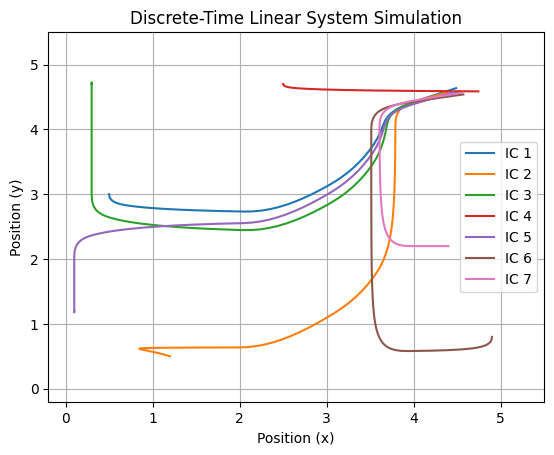

In [5]:

# Simulate the system
def trajectory(x_0):
    num_steps = 500
    x_k = x_0
    states = [x_k]
    acceleration = np.empty((2, 0))
    for i in range(num_steps):
        u_k = input(i, x_k)
        x_k = A @ x_k + B @ u_k
        states.append(x_k)
        acceleration = np.concatenate((acceleration, u_k), axis = 1)
    acceleration = np.concatenate((acceleration, u_k), axis = 1)
    # Convert states to array for analysis
    states = np.hstack(states)
    time = np.arange(num_steps + 1)
    print(f"For initial position of ({states[0, 0]}, {states[2, 0]}) and initial velocity of ({states[1, 0]}, {states[3, 0]}), the final position is ({states[0, -1]}, {states[2, -1]}), the final velocity is ({states[1, -1]}, {states[3, -1]}), and final acceleration is ({acceleration[0, -1]}, {states[1, -1]}).")
    return states, acceleration, time

# Run simulation
x_0_1 = np.array([[0.5],  # Position (x)
                [0.01],  # Velocity (x)
                [3],  # Position (y)
                [-0.5]]) # Velocity (y)
st1, ac1, time = trajectory(x_0_1)
#plt.plot(time, states[0, :], label="Position (x)")
#plt.plot(time, states[1, :], label="Velocity (x)")
#plt.plot(time, acceleration[0, :], label="Acceleration (x)")
#plt.xlabel("Time step (k)")
#plt.ylabel("State values")
#plt.legend()
#plt.title("Discrete-Time Linear System Simulation")
#plt.show()
x_0_2 = np.array([[1.2], [-0.7], [0.5], [0.3]]) 
st2, ac2, time = trajectory(x_0_2)
x_0_3 = np.array([[0.3], [0], [4.7], [0.2]])
st3, ac3, time = trajectory(x_0_3)
x_0_4 = np.array([[2.5], [0], [4.7], [-0.2]])
st4, ac4, time = trajectory(x_0_4)
x_0_5 = np.array([[0.1], [0], [1.2], [-0.2]])
st5, ac5, time = trajectory(x_0_5)
x_0_6 = np.array([[4.9], [0], [0.8], [-0.5]])
st6, ac6, time = trajectory(x_0_6)
x_0_7 = np.array([[4.4], [0], [2.2], [0]])
st7, ac7, time = trajectory(x_0_7)
plt.plot(st1[0, :], st1[2, :], label="IC 1")
plt.plot(st2[0, :], st2[2, :], label="IC 2")
plt.plot(st3[0, :], st3[2, :], label="IC 3")
plt.plot(st4[0, :], st4[2, :], label="IC 4")
plt.plot(st5[0, :], st5[2, :], label="IC 5")
plt.plot(st6[0, :], st6[2, :], label="IC 6")
plt.plot(st7[0, :], st7[2, :], label="IC 7")
plt.xlabel("Position (x)")
plt.ylabel("Position (y)")
plt.legend()
plt.title("Discrete-Time Linear System Simulation")
plt.xlim(-0.2, 5.5)
plt.ylim(-0.2, 5.5)
plt.grid()
plt.show()